# Project

In [1]:
%matplotlib inline
import numpy as np
import math
import time
from computer_vision import *
from dijkstra import compute_shortest_path
from kalman import kalman_ext_filter
import tdmclient.notebook
await tdmclient.notebook.start()


In [2]:
# parametres
speed_r = 100
speed_f = 100
stop = 0
MIN_DIST = 40
ANGLE_TOLERANCE = 0.30
PERIOD = 0.25
SPEED_AVG = 50
ROBOT_SPEED_TO_MM = 140/500

@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

def get_angle_between(vec1, vec2):
    vec1_unit = vec1 / np.linalg.norm(vec1)
    vec2_unit = vec2 / np.linalg.norm(vec2)

    return np.arccos(np.dot(vec1_unit, vec2_unit))

def distance (x1, y1, x2, y2):
    dist = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return dist

def wrap_angle(angle):
    if angle > math.pi:
        angle = angle - 2*math.pi
    elif angle < -math.pi:
        angle = angle + 2*math.pi
    return angle

In [3]:
def controller(goal_dist, angle):
    kp_rot = 50

    if abs(angle) > ANGLE_TOLERANCE:
        speed_l = - kp_rot*(angle)
        speed_r = + kp_rot*(angle)

    else:
        speed_l = SPEED_AVG
        speed_r = SPEED_AVG
    return speed_l, speed_r

In [4]:
def pathing (video_capture, filter, path, x0, y0, theta0, periode=0.01):
    # plot for camera, kalman and error
    teta = np.zeros(np.shape(path)[0])
    speed_l = speed_r = 0
    goalx = path[0][0]
    goaly = path[0][1]
    theta_measure = 0
    i = 0
    curr_time = 0
    kx = kteta = ky = angle = 0
    robot_detected = False
    camera_available = False
    dist = distance (goalx, goaly, kx, ky)
    j=0
    while True:       
        #   step 1: get the image, detect the robot, and get the position
        camera_available, frame = video_capture.read()
        position_measure = []
        if camera_available == True:
            position_measure, position_contour, proccessed_framed = computer_vision(frame, 'robot', False)
            # cv has detected the robot, we can use the position
            if len(position_measure) == 1:
                robot_detected = True
                position_measure = position_measure[0]

                if position_measure is not None:                    
                    _, theta_measure = get_robot_position(frame, position_measure, position_contour)
                    theta_measure = round(-theta_measure, 4)
                    position_measure = invert_coordinates(position_measure)
                    position_measure = pixel_to_metric(position_measure)
                    [kx, ky, kteta] = [position_measure[0], position_measure[1], theta_measure]
                    measurement = np.array([kx, ky, kteta])
                else:
                    robot_detected = False
            else:
            # robot not detected, we use kalman
                robot_detected = False

        if camera_available == False or robot_detected == False:
            measurement = np.array([0,0,0])         # CHECK WHY 0,0,0            
        
        [pred_x, pred_y, pred_teta], _, _, curr_time = filter.filter(measurement, curr_time) 
        
        dist = distance (goalx, goaly, kx, ky)
        teta[i] = math.atan2((goaly - ky), (goalx - kx)) #change angle according to kalman
    

        if (dist < MIN_DIST):
            if i < np.shape(path)[0] - 1 :
                i = i + 1
                goalx = path[i][0]
                goaly = path[i][1]
                #vec1 = [np.cos(teta[i-1]), np.sin(teta[i-1])]
                #vec2 = [goalx - kx, goaly - ky]
                #angle = get_angle_between(vec1, vec2)
            else:
                motors(stop, stop)
                break
        else :
            angle =  round(wrap_angle((teta[i] - kteta) % (2*np.pi)), 4)
            
            speed_l, speed_r = controller(dist, angle)
   
        # set input for kalman filter
        filter.u = np.array([speed_l, speed_r]) * ROBOT_SPEED_TO_MM
        motors(int(speed_l),int(speed_r))
     
     
        print(round(theta_measure,4),i, filter.dt, "error :%.3f %.3f %.4f" %(kx-pred_x, ky-pred_y, kteta-pred_teta))
    motors(stop, stop)
    

# Main 

1
2
start = [123.28942 550.74196] goal = [723.4948  661.48096] angle = 0.12927500404814304


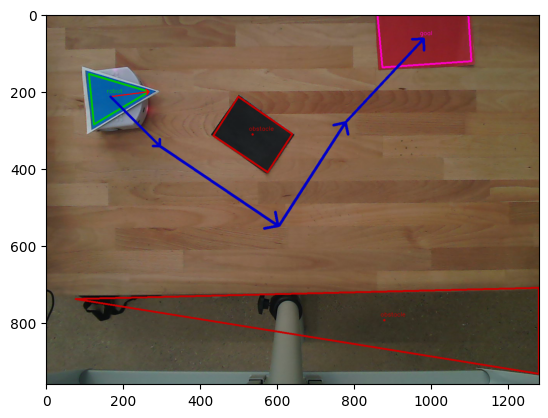

In [5]:
video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
cv_successful, obst, robot, goal, frame = cv_start(video_capture, show_image= True, exposure=-8)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
obst = format_contour(obst)

if cv_successful:
    start = np.array([robot[0], robot[1]])
    goal = np.array([goal[0], goal[1]])
    path = compute_shortest_path(obst, start, goal)
    path = np.rint(path).astype(int)
    frame = draw_path(frame, path) 
        
    metric_path = np.zeros(np.shape(path))

    # invert y axis
    for i in range(len(path)):
        path[i] = invert_coordinates(path[i])
    metric_start = invert_coordinates(start)
    metric_goal = invert_coordinates(goal)

    # change to metric  

    for i in range(len(path)):
        metric_path[i] = pixel_to_metric(path[i])
    metric_start = pixel_to_metric(metric_start)
    metric_goal = pixel_to_metric(metric_goal)
    
    
    print('start =', metric_start, 'goal =', metric_goal, 'angle =', -robot[2])


filter = kalman_ext_filter(metric_start[0], metric_start[1], -robot[2], 0, 0, PERIOD)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [8]:
#ret, frame = video_capture.read()
#print(ret)
#plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#cv2.imwrite('frame.jpeg', frame)

motors(stop, stop)
np.shape(path)
print(np.shape(path)[0])

6


In [7]:
pathing(video_capture, filter, metric_path, metric_start[0], metric_start[1], -robot[2], periode=PERIOD)
print("finished")
motors(stop, stop)


0.116 1 0.25 error :123.288 548.523 0.1160
0.1351 1 0.22 error :-23.232 266.278 0.0260
0.1255 1 0.199 error :-21.535 176.636 -0.0040
0.1351 1 0.22 error :-17.119 131.613 0.0134
0.1268 1 0.212 error :-13.688 106.030 -0.0035
0.0768 1 0.221 error :-12.218 86.872 -0.0462
-0.0096 1 0.23 error :-9.748 70.865 -0.0854
-0.0863 1 0.229 error :-8.839 60.586 -0.0785
-0.1364 1 0.223 error :-6.334 54.694 -0.0519
-0.2145 1 0.222 error :-7.080 45.450 -0.0785
-0.273 1 0.233 error :-6.197 40.707 -0.0609
-0.3218 1 0.216 error :-5.657 35.938 -0.0505
-0.4202 1 0.218 error :-4.386 33.282 -0.0997
-0.4507 1 0.22 error :-4.970 30.146 -0.0364
-0.4809 1 0.2 error :-3.947 27.488 -0.0324
-0.4978 1 0.217 error :-2.850 25.046 -0.0188
-0.5191 1 0.218 error :-1.768 22.023 -0.0224
-0.5371 1 0.201 error :-0.617 18.434 -0.0193
-0.5371 1 0.211 error :1.345 15.020 -0.0011
-0.5274 1 0.212 error :1.136 12.390 0.0096
-0.5404 1 0.207 error :2.154 8.506 -0.0124
-0.5404 1 0.214 error :1.933 6.243 -0.0007
-0.5454 1 0.205 error :2

KeyboardInterrupt: 